In [1]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim, nn
from torch.utils.data import Dataset,DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm

In [2]:
#important variables
IMAGE_SIZE = 128
num_classes = 4
batch_size = 4
LR = 1e-4
EPOCHS = 20

image_path = "dataset/dataA/CameraRGB/"
mask_path = "dataset/dataA/CameraSeg/"

In [3]:
# Load all data paths
def load_data_paths():
    image_paths = sorted(glob(os.path.join(image_path, "*.png")))
    mask_paths = sorted(glob(os.path.join(mask_path, "*.png")))
    return image_paths, mask_paths

# Load all data paths
image_paths, mask_paths = load_data_paths()

Unique pixel values in mask: [0 1 2 3]
Unique pixel values in mask: [0 1 2 3]
Unique pixel values in mask: [0 1 2 3]
Unique pixel values in mask: [0 1 2 3]


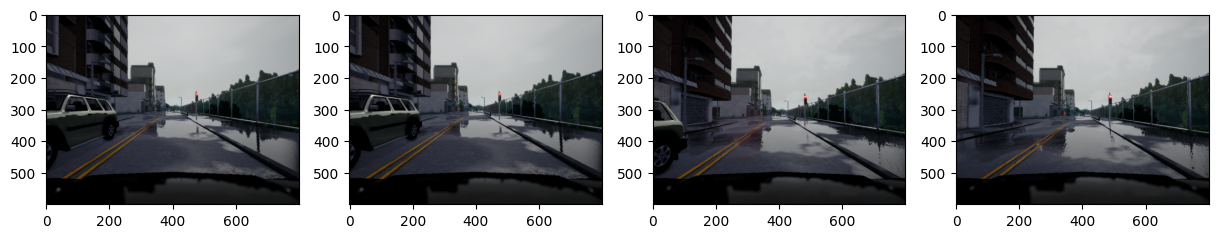

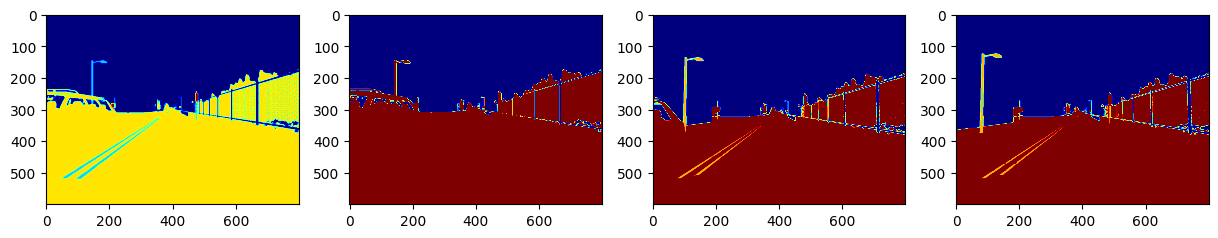

In [4]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

def read_gray_scale(y):
    y = cv2.imread(y,cv2.IMREAD_GRAYSCALE)
    print("Unique pixel values in mask:", np.unique(y))
    return y

# Plot samples of images and corresponding masks 
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(image_paths[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(image_paths[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(image_paths[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(image_paths[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_gray_scale(mask_paths[0]),cmap='jet')

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_gray_scale(mask_paths[1]),cmap='jet')
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_gray_scale(mask_paths[2]),cmap='jet')
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_gray_scale(mask_paths[3]),cmap='jet')
imgplot.set_clim(0.0, 1.4)

In [5]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding="same")
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding="same")
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x

class Encoder(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels,out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self,x):
        down = self.conv(x)
        p = self.pool(down)

        return down,p

class Decoder(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2,kernel_size =2 ,stride=2)
        self.conv = DoubleConv(in_channels,out_channels)

    def forward(self,x1,x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],1)
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.down_conv_1 = Encoder(in_channels,64)
        self.down_conv_2 = Encoder(64,128)
        self.down_conv_3 = Encoder(128,256)
        self.down_conv_4 = Encoder(256,512)

        self.bottle_neck = DoubleConv(512,1024)

        self.up_conv_1 = Decoder(1024,512)
        self.up_conv_2 = Decoder(512,256)
        self.up_conv_3 = Decoder(256,128)
        self.up_conv_4 = Decoder(128,64)

        self.out = nn.Conv2d(in_channels=64,out_channels=num_classes,kernel_size=1,padding="same")

    def forward(self,x):
        d1, p1 = self.down_conv_1(x)
        d2, p2 = self.down_conv_2(p1)
        d3, p3 = self.down_conv_3(p2)
        d4, p4 = self.down_conv_4(p3)

        b = self.bottle_neck(p4)

        up1 = self.up_conv_1(b,d4)
        up2 = self.up_conv_2(up1,d3)
        up3 = self.up_conv_3(up2,d2)
        up4 = self.up_conv_4(up3,d1)

        out = self.out(up4)

        return out

In [6]:
#Model 
model = Unet(3,num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Model Testing
# input_image = torch.rand((1,3,128,128))
# output = model(input_image)
# print(output.size())

In [7]:
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
           Encoder-9  [[-1, 64, 128, 128], [-1, 64, 64, 64]]               0
           Conv2d-10          [-1, 128, 64, 64]          73,856
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
      BatchNorm2d-14      

In [8]:
class ImageMaskDataset(Dataset):
    def __init__(self,image_paths, mask_paths, image_size,num_classes):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self,index):
        image = self.read_image(self.image_paths[index])
        mask = self.read_mask(self.mask_paths[index])

        return torch.tensor(image,dtype=torch.float32) , torch.tensor(mask, dtype=torch.uint8)

    def read_image(self,path):
        x = cv2.imread(path, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (self.image_size,self.image_size))
        x = x / 255.0
        return x.transpose(2,0,1)

    def read_mask(self, path):
        x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        x = cv2.resize(x, (self.image_size, self.image_size))
        # x = np.expand_dims(x, axis=-1)

        # output = []
        # for i in range(self.num_classes):
        #     cmap = np.all(np.equal(x, i), axis=-1)
        #     output.append(cmap)
        # output = np.stack(output, axis=0) 
        # return output.astype(np.uint8)
        return x.astype(np.uint8)
        

In [9]:
# Create the full dataset
full_dataset = ImageMaskDataset(image_paths, mask_paths, IMAGE_SIZE, num_classes)

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
valid_size = int(0.1 * len(full_dataset))  # 10% for validation
test_size = len(full_dataset) - train_size - valid_size  # Remaining 10% for testing

train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

In [10]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [11]:
print(train_loader.dataset[0][1].dtype)
for idx,img in enumerate(train_loader):
    print(idx,len(img))
    break
print(train_loader.dataset[0][1].shape)
print(train_loader.dataset[0][1])

torch.uint8
0 2
torch.Size([128, 128])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.uint8)


In [12]:
#Compiling the model:
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [13]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [14]:
torch.cuda.empty_cache()

In [15]:
#Training the model:
train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch +1}/{EPOCHS}")
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, train_img in enumerate(tqdm(train_loader)):
        img = train_img[0].float().to(device)
        mask = train_img[1].long().to(device)
        
        #forward pass
        y_pred = model(img)
        optimizer.zero_grad()

        #Loss calculate
        one_hot_mask = F.one_hot(mask, num_classes=num_classes)  # Shape: (N, H, W, C)
        one_hot_mask = one_hot_mask.permute(0, 3, 1, 2).float()
        dc = dice_coefficient(y_pred, one_hot_mask)
        loss = criterion(y_pred, mask)
        
        #Loss added to list
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        #Backprop
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, val_img in enumerate(tqdm(valid_loader)):
            img = val_img[0].float().to(device)
            mask = val_img[1].long().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            one_hot_mask = F.one_hot(mask, num_classes=num_classes)  # Shape: (N, H, W, C)
            one_hot_mask = one_hot_mask.permute(0, 3, 1, 2).float()
            dc = dice_coefficient(y_pred, one_hot_mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

# Saving the model
torch.save(model.state_dict(), 'my_checkpoint.pth')

Epoch 1/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.02it/s]


------------------------------
Training Loss EPOCH 1: 0.6319
Training DICE EPOCH 1: 0.5724


Validation Loss EPOCH 1: 1.0016
Validation DICE EPOCH 1: 0.6255
------------------------------
Epoch 2/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.03it/s]


------------------------------
Training Loss EPOCH 2: 0.3448
Training DICE EPOCH 2: 0.8404


Validation Loss EPOCH 2: 1.0416
Validation DICE EPOCH 2: 0.5374
------------------------------
Epoch 3/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.35it/s]


------------------------------
Training Loss EPOCH 3: 0.2541
Training DICE EPOCH 3: 0.9195


Validation Loss EPOCH 3: 0.9691
Validation DICE EPOCH 3: 0.5884
------------------------------
Epoch 4/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.45it/s]


------------------------------
Training Loss EPOCH 4: 0.2076
Training DICE EPOCH 4: 0.9276


Validation Loss EPOCH 4: 0.7346
Validation DICE EPOCH 4: 0.7299
------------------------------
Epoch 5/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.39it/s]


------------------------------
Training Loss EPOCH 5: 0.1781
Training DICE EPOCH 5: 0.9331


Validation Loss EPOCH 5: 0.6854
Validation DICE EPOCH 5: 0.7245
------------------------------
Epoch 6/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.56it/s]


------------------------------
Training Loss EPOCH 6: 0.1621
Training DICE EPOCH 6: 0.9339


Validation Loss EPOCH 6: 0.7837
Validation DICE EPOCH 6: 0.7074
------------------------------
Epoch 7/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.40it/s]


------------------------------
Training Loss EPOCH 7: 0.1432
Training DICE EPOCH 7: 0.9383


Validation Loss EPOCH 7: 0.6779
Validation DICE EPOCH 7: 0.8245
------------------------------
Epoch 8/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 26.80it/s]


------------------------------
Training Loss EPOCH 8: 0.1414
Training DICE EPOCH 8: 0.9356


Validation Loss EPOCH 8: 0.6855
Validation DICE EPOCH 8: 0.7710
------------------------------
Epoch 9/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.42it/s]


------------------------------
Training Loss EPOCH 9: 0.1259
Training DICE EPOCH 9: 0.9399


Validation Loss EPOCH 9: 0.5726
Validation DICE EPOCH 9: 0.8193
------------------------------
Epoch 10/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.30it/s]


------------------------------
Training Loss EPOCH 10: 0.1151
Training DICE EPOCH 10: 0.9429


Validation Loss EPOCH 10: 0.5863
Validation DICE EPOCH 10: 0.8325
------------------------------
Epoch 11/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.68it/s]


------------------------------
Training Loss EPOCH 11: 0.1082
Training DICE EPOCH 11: 0.9441


Validation Loss EPOCH 11: 0.5928
Validation DICE EPOCH 11: 0.8083
------------------------------
Epoch 12/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.46it/s]


------------------------------
Training Loss EPOCH 12: 0.1001
Training DICE EPOCH 12: 0.9465


Validation Loss EPOCH 12: 0.5288
Validation DICE EPOCH 12: 0.8268
------------------------------
Epoch 13/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.26it/s]


------------------------------
Training Loss EPOCH 13: 0.0942
Training DICE EPOCH 13: 0.9479


Validation Loss EPOCH 13: 0.5248
Validation DICE EPOCH 13: 0.8232
------------------------------
Epoch 14/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.32it/s]


------------------------------
Training Loss EPOCH 14: 0.0886
Training DICE EPOCH 14: 0.9493


Validation Loss EPOCH 14: 0.4695
Validation DICE EPOCH 14: 0.8477
------------------------------
Epoch 15/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.43it/s]


------------------------------
Training Loss EPOCH 15: 0.0867
Training DICE EPOCH 15: 0.9491


Validation Loss EPOCH 15: 0.5136
Validation DICE EPOCH 15: 0.8191
------------------------------
Epoch 16/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.11it/s]


------------------------------
Training Loss EPOCH 16: 0.0822
Training DICE EPOCH 16: 0.9504


Validation Loss EPOCH 16: 0.5725
Validation DICE EPOCH 16: 0.8032
------------------------------
Epoch 17/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.28it/s]


------------------------------
Training Loss EPOCH 17: 0.0779
Training DICE EPOCH 17: 0.9517


Validation Loss EPOCH 17: 0.6561
Validation DICE EPOCH 17: 0.7445
------------------------------
Epoch 18/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.28it/s]


------------------------------
Training Loss EPOCH 18: 0.0733
Training DICE EPOCH 18: 0.9529


Validation Loss EPOCH 18: 0.5863
Validation DICE EPOCH 18: 0.7857
------------------------------
Epoch 19/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.35it/s]


------------------------------
Training Loss EPOCH 19: 0.0718
Training DICE EPOCH 19: 0.9531


Validation Loss EPOCH 19: 0.5744
Validation DICE EPOCH 19: 0.7793
------------------------------
Epoch 20/20


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 27.40it/s]


------------------------------
Training Loss EPOCH 20: 0.0678
Training DICE EPOCH 20: 0.9542


Validation Loss EPOCH 20: 0.6540
Validation DICE EPOCH 20: 0.7796
------------------------------


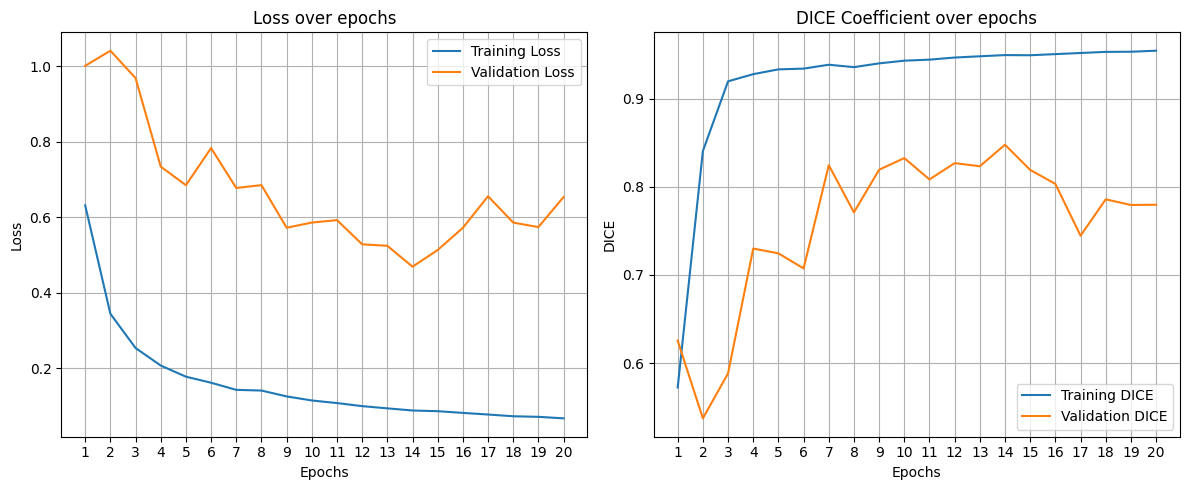

In [20]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
#Testing:
model = model.to(device)
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, test_img in enumerate(test_loader):
        img = test_img[0].to(device)
        mask = test_img[1].long().to(device)

        y_pred = model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)

In [23]:
print(f"Test loss:{test_loss} and Test dc:{test_dc}")

Test loss:0.6743722176551818 and Test dc:1.1985964012145995


torch.Size([3, 128, 128]) torch.Size([128, 128])
torch.Size([1, 4, 128, 128])


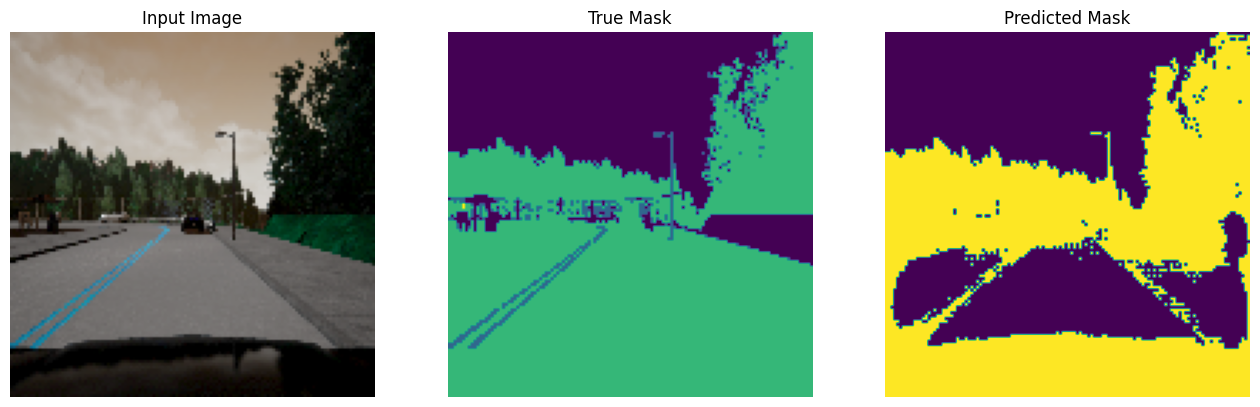

In [37]:
def display_sample(display_list):
    plt.figure(figsize=(16, 16))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(transforms.ToPILImage()(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, axis=0) 
    pred_mask = torch.unsqueeze(pred_mask, axis=0)
    return pred_mask
    
def show_predictions():
    print(sample_image.shape, sample_mask.shape)
    sample_img = sample_image.reshape(1,3,128,128)
    prediction = model.to("cpu")(sample_img)
    print(prediction.shape)
    prediction = prediction.reshape(4,128,128)
    pred_mask = create_mask(prediction)
    pred_mask = pred_mask.to(dtype=torch.uint8)
    # original_mask = torch.argmax(sample_mask, axis=0)
    # original_mask = torch.unsqueeze(original_mask,axis=0)
    original_mask = torch.unsqueeze(sample_mask,axis=0)
    original_mask = original_mask.to(dtype=torch.uint8)
    display_sample([sample_image, original_mask, pred_mask])
    
sample_image , sample_mask = test_loader.dataset[6]

show_predictions()